# Capstone Project - Machine Learning Analysis

**Objective**: Sales forecast for the upcoming two months for 14 different products. In this notebook, we will be taking a ML approach to the problem. Data exploration and feature engineering will be implemented in an attempt to create an accurate model. The data needs to be transformed into a supervised learning problem using sliding window techniques.

**Dataset**: A CSV file containing three different columns:
- Year-Week: Year and number of week corresponding to the Units column
- ID_Material: Internal identification number of the product
- Units: Amount sold for each product, which is also our target variable

Imported Libraries are as follows: 

In [101]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import balanced_accuracy_score

## 1. Data Ingestion and Cleaning 

In [102]:
data = pd.read_excel("IE KPMG-Demand Forecast dataset.xlsx")

In [103]:
data

,year-week,ID_material,Units
0,2019-11,120010970.0,540.0
1,2019-12,120010970.0,750.0
2,2019-13,120010970.0,960.0
3,2019-14,120010970.0,720.0
4,2019-15,120010970.0,1620.0
...,...,...,...
2852,2022-35,120015996.0,948.0
2853,2022-36,120015996.0,600.0
2854,2022-37,120015996.0,1452.0
2855,2022-38,120015996.0,1920.0


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857 entries, 0 to 2856
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year-week    2857 non-null   object 
 1   ID_material  2857 non-null   float64
 2   Units        2857 non-null   float64
dtypes: float64(2), object(1)
memory usage: 67.1+ KB


We will make a change to one of the variable types: ID_material

It is better to view it as a string due to the insignificance of the ID value itself. It is used merely to distinguish between different types of materials (categorical nature)

In [105]:
data["ID_material"] = data["ID_material"].astype('str')

Additionally, we will try to parse our year-week variable into a Date format in order to visualise any potential seasonality or time series values. 

In [106]:
data["year"] = data['year-week'].str[:4]
data["week"] = data['year-week'].str[-2:]

In order to create a date type, we must assume a day value for each week-year combination. Let us assume day 0 for simplicity 

In [107]:
date = data['year'] + data['week'] + '0'
data['Date'] = pd.to_datetime(date, format='%Y%U%w')

In [108]:
data = data.drop("year-week", axis = 1)

In [109]:
data["year"] = data["year"].astype('int')
data["week"] = data["week"].astype('int')

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857 entries, 0 to 2856
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID_material  2857 non-null   object        
 1   Units        2857 non-null   float64       
 2   year         2857 non-null   int64         
 3   week         2857 non-null   int64         
 4   Date         2857 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 111.7+ KB


In [111]:
data

,ID_material,Units,year,week,Date
0,120010970.0,540.0,2019,11,2019-03-17
1,120010970.0,750.0,2019,12,2019-03-24
2,120010970.0,960.0,2019,13,2019-03-31
3,120010970.0,720.0,2019,14,2019-04-07
4,120010970.0,1620.0,2019,15,2019-04-14
...,...,...,...,...,...
2852,120015996.0,948.0,2022,35,2022-08-28
2853,120015996.0,600.0,2022,36,2022-09-04
2854,120015996.0,1452.0,2022,37,2022-09-11
2855,120015996.0,1920.0,2022,38,2022-09-18


## 2. Data Exploration

In [112]:
data["ID_material"].unique()

array(['120010970.0', '120012606.0', '120011556.0', '120010566.0',
       '120010342.0', '120009814.0', '120015842.0', '120012154.0',
       '120004096.0', '120009816.0', '120011782.0', '120014486.0',
       '120014488.0', '120015996.0'], dtype=object)

The first step in the data exploration is to segregate the dataset into each product's respective demand and attempt to identify any potential seasonality or correlations between products

In [113]:
data_120010970 = data[data["ID_material"] == '120010970.0']
data_120012606 = data[data["ID_material"] == '120012606.0']
data_120011556 = data[data["ID_material"] == '120011556.0']
data_120010566 = data[data["ID_material"] == '120010566.0']
data_120010342 = data[data["ID_material"] == '120010342.0']
data_120009814 = data[data["ID_material"] == '120009814.0']
data_120015842 = data[data["ID_material"] == '120015842.0']
data_120012154 = data[data["ID_material"] == '120012154.0']
data_120004096 = data[data["ID_material"] == '120004096.0']
data_120009816 = data[data["ID_material"] == '120009816.0']
data_120011782 = data[data["ID_material"] == '120011782.0']
data_120014486 = data[data["ID_material"] == '120014486.0']
data_120014488 = data[data["ID_material"] == '120014488.0']
data_120015996 = data[data["ID_material"] == '120015996.0']

Text(0.5, 1.0, 'data_120015996')

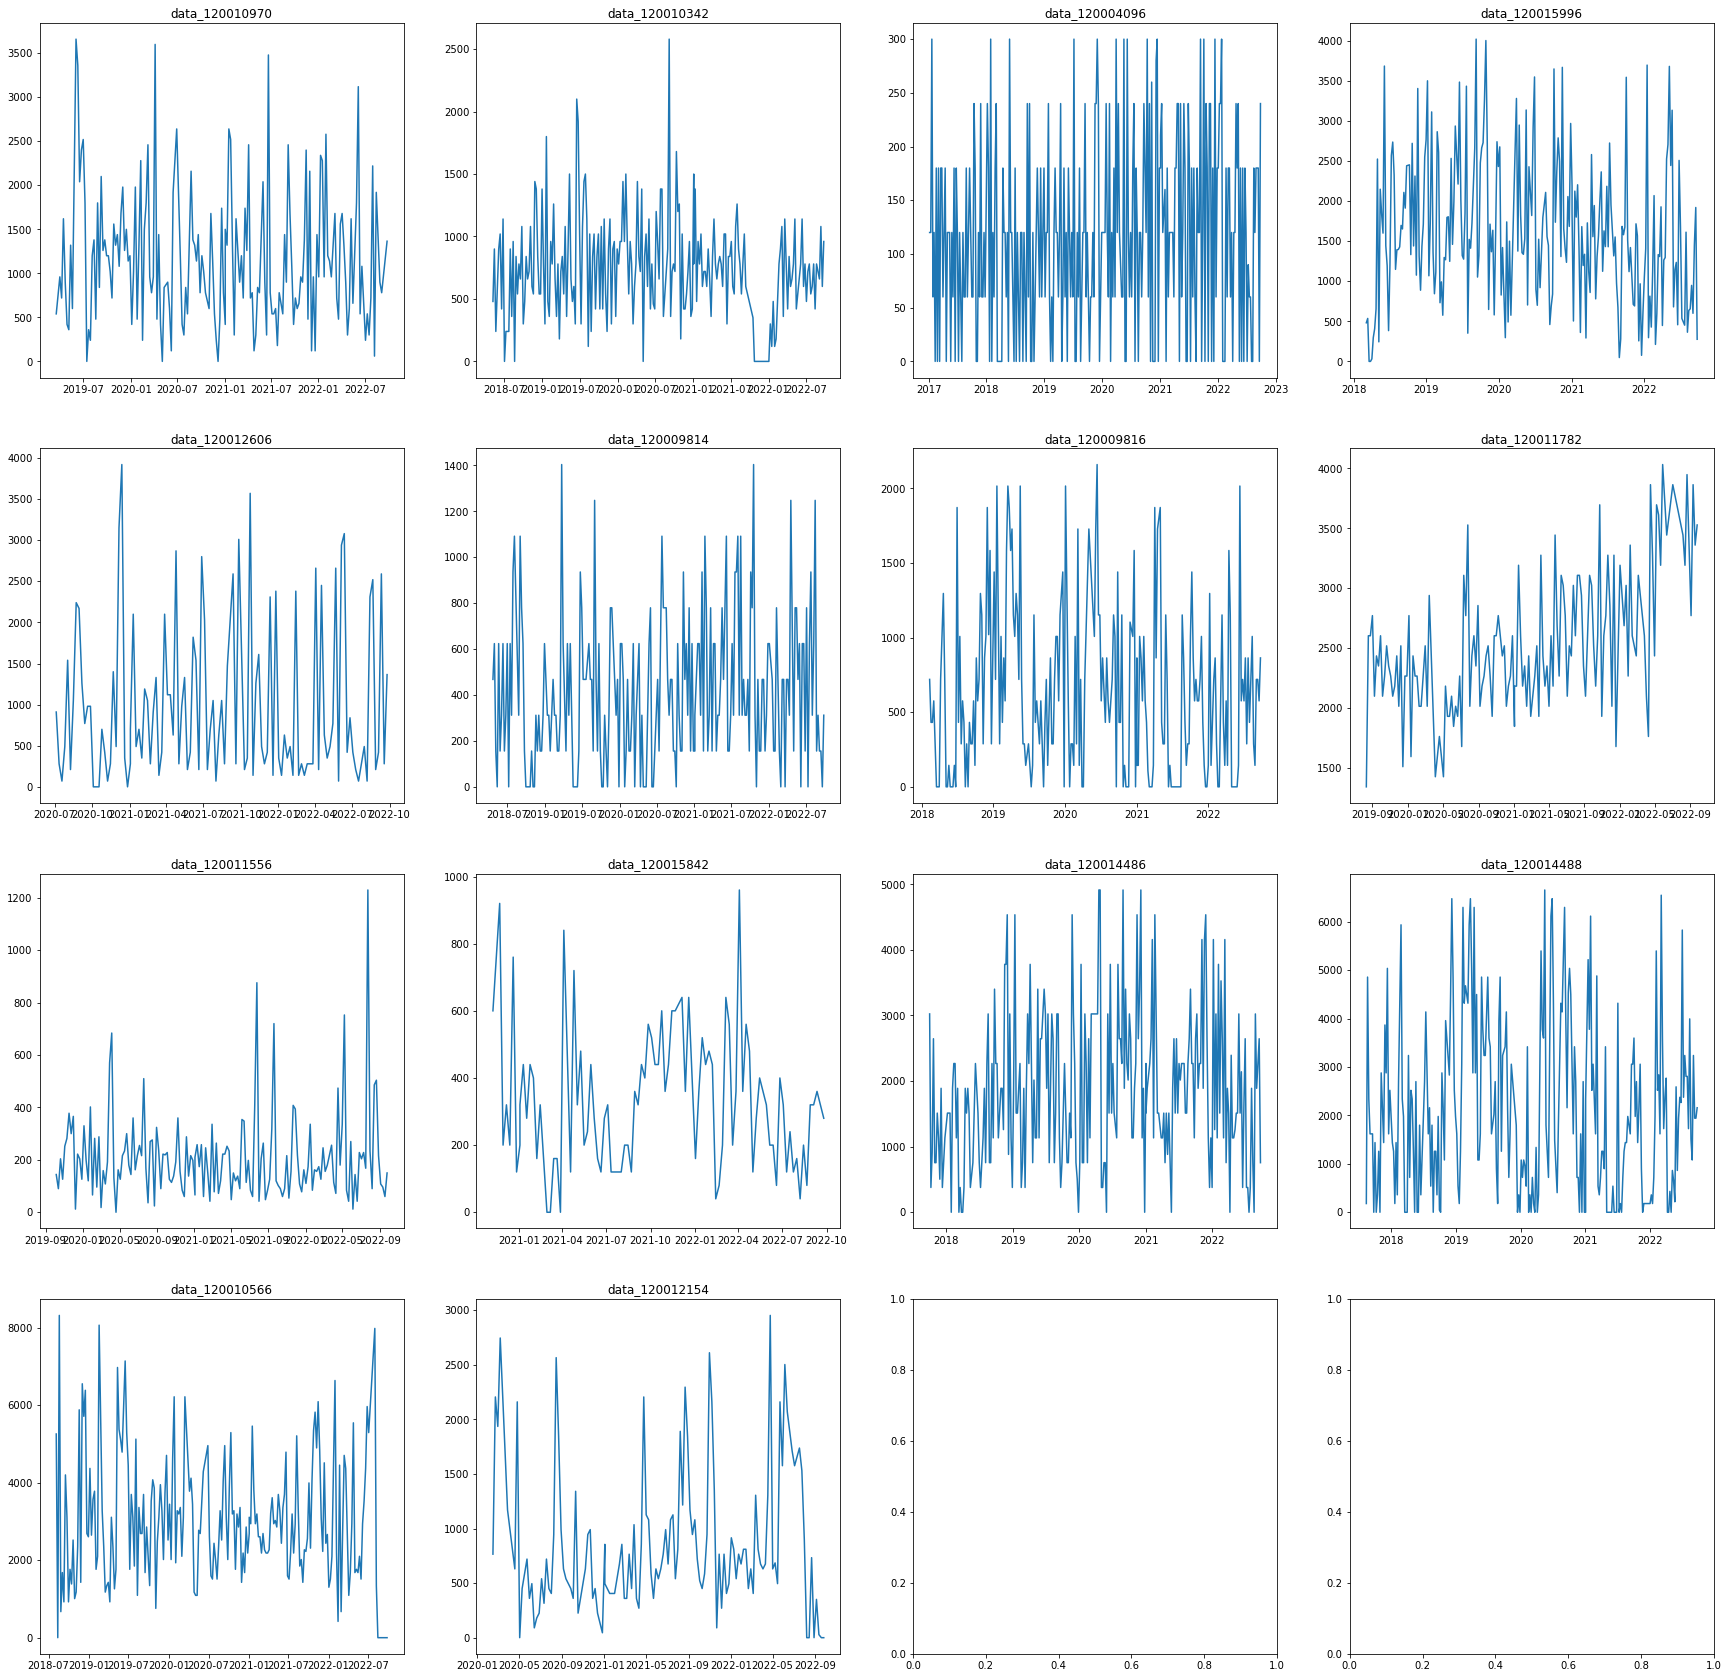

In [114]:
fig, axs = plt.subplots(4, 4,figsize=(30, 30))


axs[0, 0].plot(data_120010970["Date"], data_120010970["Units"])
axs[0, 0].set_title('data_120010970')

axs[1, 0].plot(data_120012606["Date"], data_120012606["Units"])
axs[1, 0].set_title('data_120012606')

axs[2, 0].plot(data_120011556["Date"], data_120011556["Units"])
axs[2, 0].set_title('data_120011556')

axs[3, 0].plot(data_120010566["Date"], data_120010566["Units"])
axs[3, 0].set_title('data_120010566')

axs[0, 1].plot(data_120010342["Date"], data_120010342["Units"])
axs[0, 1].set_title('data_120010342')

axs[1, 1].plot(data_120009814["Date"], data_120009814["Units"])
axs[1, 1].set_title('data_120009814')

axs[2, 1].plot(data_120015842["Date"], data_120015842["Units"])
axs[2, 1].set_title('data_120015842')

axs[3, 1].plot(data_120012154["Date"], data_120012154["Units"])
axs[3, 1].set_title('data_120012154')

axs[0, 2].plot(data_120004096["Date"], data_120004096["Units"])
axs[0, 2].set_title('data_120004096')

axs[1, 2].plot(data_120009816["Date"], data_120009816["Units"])
axs[1, 2].set_title('data_120009816')

axs[1, 3].plot(data_120011782["Date"], data_120011782["Units"])
axs[1, 3].set_title('data_120011782')

axs[2, 2].plot(data_120014486["Date"], data_120014486["Units"])
axs[2, 2].set_title('data_120014486')

axs[2, 3].plot(data_120014488["Date"], data_120014488["Units"])
axs[2, 3].set_title('data_120014488')

axs[0, 3].plot(data_120015996["Date"], data_120015996["Units"])
axs[0, 3].set_title('data_120015996')

As can be seen above, each product's units sold oveer the past years appears to be quite volatile with no apparent trend or seasonality. Now let's try grouping these demand cycles by date in order to aggregate all materials together. There may be some potential interesting correlations between products 

In [115]:
data_grouped =  data.groupby(by = "Date", as_index = False).mean()
data_grouped

,Date,Units,year,week
0,2017-01-08,120.000000,2017.0,2.0
1,2017-01-15,120.000000,2017.0,3.0
2,2017-01-22,300.000000,2017.0,4.0
3,2017-01-29,60.000000,2017.0,5.0
4,2017-02-05,120.000000,2017.0,6.0
...,...,...,...,...
293,2022-08-28,815.285714,2022.0,35.0
294,2022-09-04,871.214286,2022.0,36.0
295,2022-09-11,1122.357143,2022.0,37.0
296,2022-09-18,919.714286,2022.0,38.0


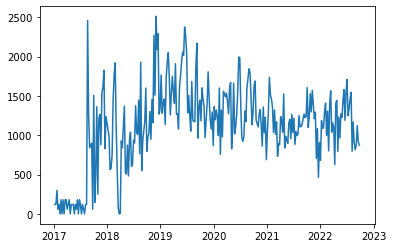

In [116]:
plt.plot(data_grouped["Date"], data_grouped["Units"])

Similar conclusion as before can be made with the distribution appearing to be non cyclical with a constant change in variance.

## 3. Building the Model

Our feature engineering consists of altering the data into a supervised machine learning structure. This will allow us to apply ML algrithms coinciding with the nature of the time series data. 

Additionally, due to the large amount of noise within the dataset, we deemed it suitable to alter our target variable to computing the 2 month moving average of the next 8 weeks. This will maintian the current trends within the datat while allowing for more flexibility for the model

In [117]:
mo_avg = data.copy()
#mo_avg['mo_avg_1mo'] = mo_avg.groupby('ID_material')['Units'].shift().transform(lambda x: x.rolling(4).mean())
mo_avg['mo_avg_2mo'] = mo_avg.groupby('ID_material')['Units'].shift().transform(lambda x: x.rolling(8).mean())
#mo_avg['mo_avg_3mo'] = mo_avg.groupby('ID_material')['Units'].shift().transform(lambda x: x.rolling(12).mean())
mo_avg

,ID_material,Units,year,week,Date,mo_avg_2mo
0,120010970.0,540.0,2019,11,2019-03-17,NaN
1,120010970.0,750.0,2019,12,2019-03-24,NaN
2,120010970.0,960.0,2019,13,2019-03-31,NaN
3,120010970.0,720.0,2019,14,2019-04-07,NaN
4,120010970.0,1620.0,2019,15,2019-04-14,NaN
...,...,...,...,...,...,...
2852,120015996.0,948.0,2022,35,2022-08-28,803.25
2853,120015996.0,600.0,2022,36,2022-09-04,712.25
2854,120015996.0,1452.0,2022,37,2022-09-11,720.25
2855,120015996.0,1920.0,2022,38,2022-09-18,840.00


## Decision Trees for Time Series

Here a series of functions have been created in order to apply the data modifications and necessary sliding windows while using Decision tree algorithms to predict next week's 2 month moving average.

In [118]:
def retrieve_val(data):
    data = data[["Date","mo_avg_2mo"]]
    data.index = data['Date']
    data = data.loc[:, data.columns != "Date"]

    values = data.values
    return values


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
 # put it all together
 agg = pd.concat(cols, axis=1)
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
 return agg.values


def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]


# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = np.asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000,
                               max_depth= 39,
                                min_samples_split=19,
                                min_samples_leaf=7,
                               random_state = 0)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0],model

# fit an random forest model and make a one step prediction
def gradient_boosting_forecast(train, testX):
 # transform list into array
 train = np.asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = GradientBoostingRegressor(n_estimators=1000,
                               max_depth= 39,
                                min_samples_split=19,
                                min_samples_leaf=7, 
                                  random_state = 0)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0],model


def walk_forward_validation(data, model_type, n_test):
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
     testX, testy = test[i, :-1], test[i, -1]
 # fit model on history and make a prediction
     yhat, model = model_type(history, testX)
 # store forecast in list of predictions
     predictions.append(yhat)
 # add actual observation to history for the next loop
     history.append(test[i])
 # summarize progress
     print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

 # estimate prediction error
 accuracy = model.score(test[:, :-1], test[:, -1])
 mae = mean_absolute_error(test[:, -1], predictions)
 mape = mean_absolute_percentage_error(test[:, -1], predictions)
 return  accuracy, mape, mae, test[:, -1], predictions

## Random Forest

We have decided to use the previous four "2-month moving average" as to avoid overfitting the model while guaranteeing valuable information as a span of 12 weeks is taken into account (4th prior 2-month moving average)

>expected=787.5, predicted=888.6
>expected=727.5, predicted=837.8
>expected=832.5, predicted=804.5
>expected=926.2, predicted=918.3
>expected=1008.8, predicted=943.0
>expected=1038.8, predicted=1118.0
>expected=1123.1, predicted=1107.3
>expected=1179.4, predicted=1231.2
Accuracy: 0.839
MAE: 57.485
MAPE: 0.065
ID_material:  120010970.0


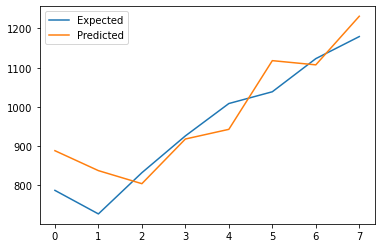

>expected=726.2, predicted=1003.8
>expected=350.0, predicted=730.3
>expected=586.2, predicted=626.5
>expected=796.2, predicted=602.3
>expected=770.0, predicted=688.7
>expected=796.2, predicted=700.2
>expected=1111.2, predicted=729.7
>expected=1111.2, predicted=1071.6
Accuracy: 0.300
MAE: 186.332
MAPE: 0.298
ID_material:  120012606.0


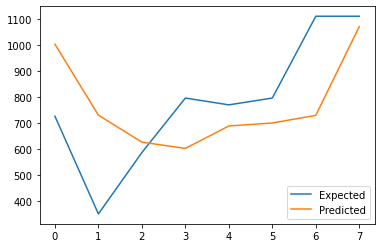

>expected=309.8, predicted=256.2
>expected=303.0, predicted=260.0
>expected=358.5, predicted=262.2
>expected=393.0, predicted=254.6
>expected=394.5, predicted=275.0
>expected=379.5, predicted=292.1
>expected=370.5, predicted=305.4
>expected=224.2, predicted=316.3
Accuracy: -0.208
MAE: 86.912
MAPE: 0.257
ID_material:  120011556.0


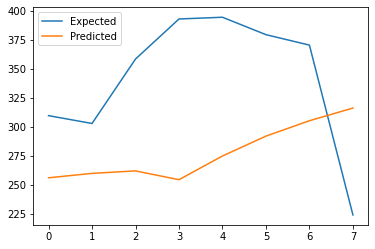

>expected=5880.0, predicted=4644.0
>expected=5607.0, predicted=4754.9
>expected=5061.0, predicted=4849.7
>expected=4315.5, predicted=4902.3
>expected=3654.0, predicted=4293.5
>expected=2908.5, predicted=3549.8
>expected=2079.0, predicted=2781.1
>expected=1165.5, predicted=2118.7
Accuracy: 0.820
MAE: 727.786
MAPE: 0.261
ID_material:  120010566.0


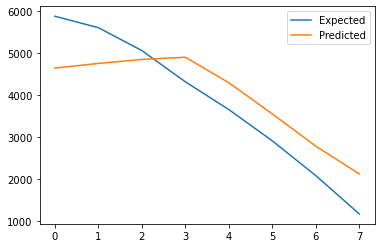

>expected=705.0, predicted=730.0
>expected=660.0, predicted=715.0
>expected=637.5, predicted=695.7
>expected=637.5, predicted=635.3
>expected=667.5, predicted=633.2
>expected=660.0, predicted=702.0
>expected=697.5, predicted=679.1
>expected=705.0, predicted=709.6
Accuracy: -0.358
MAE: 29.958
MAPE: 0.045
ID_material:  120010342.0


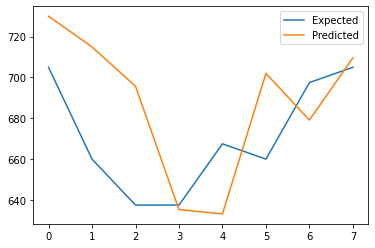

>expected=507.0, predicted=479.4
>expected=507.0, predicted=525.0
>expected=585.0, predicted=506.9
>expected=585.0, predicted=595.7
>expected=526.5, predicted=596.3
>expected=546.0, predicted=503.2
>expected=487.5, predicted=504.6
>expected=370.5, predicted=489.8
Accuracy: 0.254
MAE: 47.919
MAPE: 0.101
ID_material:  120009814.0


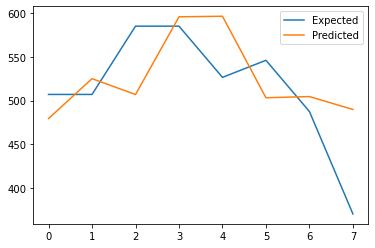

>expected=205.0, predicted=210.6
>expected=185.0, predicted=205.9
>expected=200.0, predicted=199.7
>expected=160.0, predicted=199.0
>expected=160.0, predicted=194.1
>expected=185.0, predicted=190.6
>expected=200.0, predicted=188.7
>expected=225.0, predicted=191.2
Accuracy: 0.034
MAE: 18.831
MAPE: 0.104
ID_material:  120015842.0


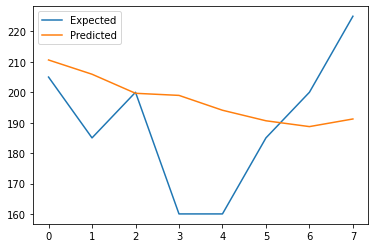

>expected=1633.5, predicted=1528.0
>expected=1374.8, predicted=1541.8
>expected=1138.5, predicted=1477.7
>expected=1016.4, predicted=1101.3
>expected=819.5, predicted=1047.7
>expected=656.4, predicted=856.4
>expected=442.8, predicted=653.5
>expected=251.5, predicted=443.7
Accuracy: 0.840
MAE: 190.970
MAPE: 0.299
ID_material:  120012154.0


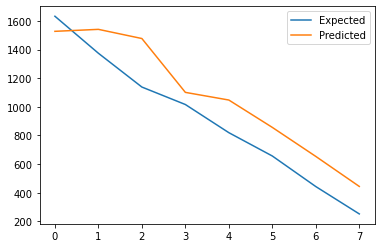

>expected=63.8, predicted=89.0
>expected=63.8, predicted=77.3
>expected=63.8, predicted=74.4
>expected=63.8, predicted=73.4
>expected=86.2, predicted=72.5
>expected=97.5, predicted=86.2
>expected=112.5, predicted=102.4
>expected=105.0, predicted=109.3
Accuracy: 0.632
MAE: 12.303
MAPE: 0.166
ID_material:  120004096.0


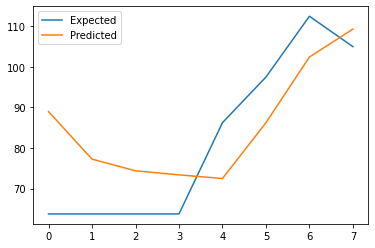

>expected=792.0, predicted=757.5
>expected=630.0, predicted=786.5
>expected=684.0, predicted=606.0
>expected=630.0, predicted=619.5
>expected=576.0, predicted=610.0
>expected=558.0, predicted=578.6
>expected=612.0, predicted=532.5
>expected=576.0, predicted=581.6
Accuracy: 0.313
MAE: 52.388
MAPE: 0.082
ID_material:  120009816.0


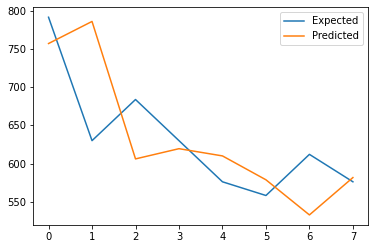

>expected=3654.0, predicted=3406.7
>expected=3654.0, predicted=3458.0
>expected=3605.0, predicted=3499.3
>expected=3633.0, predicted=3523.2
>expected=3570.0, predicted=3544.2
>expected=3444.0, predicted=3552.2
>expected=3465.0, predicted=3547.1
>expected=3433.5, predicted=3542.8
Accuracy: -0.027
MAE: 123.009
MAPE: 0.034
ID_material:  120011782.0


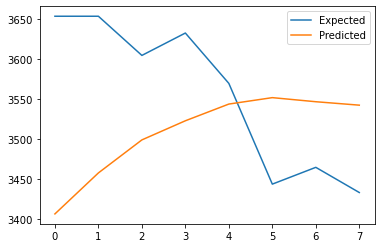

>expected=992.2, predicted=1148.2
>expected=960.8, predicted=996.6
>expected=1008.0, predicted=961.9
>expected=803.2, predicted=1044.5
>expected=850.5, predicted=942.6
>expected=1039.5, predicted=926.1
>expected=1275.8, predicted=1066.7
>expected=1606.5, predicted=1396.3
Accuracy: 0.678
MAE: 138.006
MAPE: 0.132
ID_material:  120014486.0


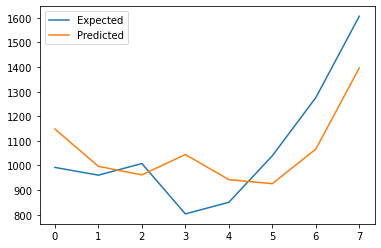

>expected=2956.5, predicted=2632.8
>expected=2929.5, predicted=3104.1
>expected=3132.0, predicted=3012.9
>expected=3037.5, predicted=3149.5
>expected=2443.5, predicted=3089.1
>expected=2551.5, predicted=2371.3
>expected=2389.5, predicted=2487.0
>expected=2281.5, predicted=2299.3
Accuracy: 0.555
MAE: 208.801
MAPE: 0.078
ID_material:  120014488.0


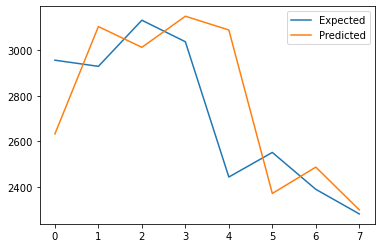

>expected=1121.1, predicted=1083.6
>expected=1012.2, predicted=1115.4
>expected=1034.6, predicted=1075.0
>expected=803.2, predicted=1101.9
>expected=712.2, predicted=1063.7
>expected=720.2, predicted=1025.6
>expected=840.0, predicted=985.6
>expected=1023.5, predicted=953.7
Accuracy: -0.138
MAE: 168.974
MAPE: 0.213
ID_material:  120015996.0


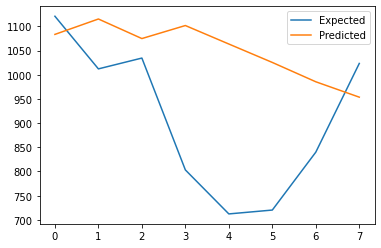

In [119]:
for i in mo_avg["ID_material"].unique():
    j = mo_avg[mo_avg["ID_material"] == i]
    values = retrieve_val(j)
    new_data = series_to_supervised(values, n_in=4)
    accuracy, mape, mae, y, yhat = walk_forward_validation(new_data,random_forest_forecast, 8)
    print('Accuracy: %.3f' % accuracy)
    print('MAE: %.3f' % mae)
    print('MAPE: %.3f' % mape)

    # plot expected vs predicted
    print("ID_material: ", i)
    plt.plot(y, label='Expected')
    plt.plot(yhat, label='Predicted')
    plt.legend()
    plt.show()
    


### Results: 
We have some very interesting results with the Random Forest Regressor being able to accurately 3 items at more than  80% on our test set. Issues with the other ID_materials range from insufficient data to signifanct amounts of noise  
- 120010970.0 --> 83.9% Accuracy
- 120010566.0 --> 82% Accuracy 
- 120012154.0 --> 84% Accuracy 

Although the accuracy is quite low for other ID_materials, it is important to consider how the Mean Absolute Percentage Errors are significantly low which is also a valid evaluation metric for Regression techniques

Following this we will generate the next 8 week predictions of each ID_material

Input: [1008.75  1038.75  1123.125 1179.375], Predicted: 1233.747
Input: [1038.75  1123.125 1179.375 1233.747], Predicted: 1230.519
Input: [1123.125 1179.375 1233.747 1230.519], Predicted: 1192.519
Input: [1179.375 1233.747 1230.519 1192.519], Predicted: 1182.237
Input: [1233.747 1230.519 1192.519 1182.237], Predicted: 1181.053
Input: [1230.519 1192.519 1182.237 1181.053], Predicted: 1171.184
Input: [1192.519 1182.237 1181.053 1171.184], Predicted: 1168.551
Input: [1182.237 1181.053 1171.184 1168.551], Predicted: 1168.613
ID_Material 120010970.0


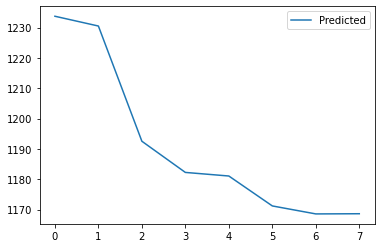

Input: [ 770.    796.25 1111.25 1111.25], Predicted: 1103.771
Input: [ 796.25  1111.25  1111.25  1103.771], Predicted: 1115.904
Input: [1111.25  1111.25  1103.771 1115.904], Predicted: 1066.068
Input: [1111.25  1103.771 1115.904 1066.068], Predicted: 1040.764
Input: [1103.771 1115.904 1066.068 1040.764], Predicted: 1021.590
Input: [1115.904 1066.068 1040.764 1021.59 ], Predicted: 1024.063
Input: [1066.068 1040.764 1021.59  1024.063], Predicted: 1034.175
Input: [1040.764 1021.59  1024.063 1034.175], Predicted: 1034.738
ID_Material 120012606.0


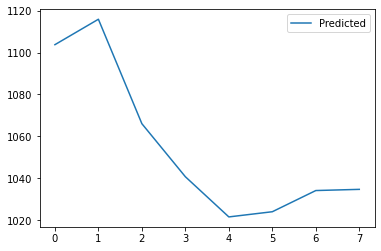

Input: [394.5  379.5  370.5  224.25], Predicted: 215.893
Input: [379.5   370.5   224.25  215.893], Predicted: 212.823
Input: [370.5   224.25  215.893 212.823], Predicted: 209.670
Input: [224.25  215.893 212.823 209.67 ], Predicted: 213.301
Input: [215.893 212.823 209.67  213.301], Predicted: 214.427
Input: [212.823 209.67  213.301 214.427], Predicted: 215.342
Input: [209.67  213.301 214.427 215.342], Predicted: 215.821
Input: [213.301 214.427 215.342 215.821], Predicted: 215.771
ID_Material 120011556.0


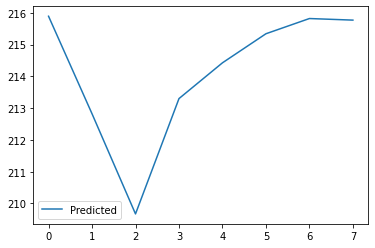

Input: [3654.  2908.5 2079.  1165.5], Predicted: 2012.296
Input: [2908.5   2079.    1165.5   2012.296], Predicted: 2018.520
Input: [2079.    1165.5   2012.296 2018.52 ], Predicted: 2022.735
Input: [1165.5   2012.296 2018.52  2022.735], Predicted: 2022.735
Input: [2012.296 2018.52  2022.735 2022.735], Predicted: 2022.735
Input: [2018.52  2022.735 2022.735 2022.735], Predicted: 2022.735
Input: [2022.735 2022.735 2022.735 2022.735], Predicted: 2022.735
Input: [2022.735 2022.735 2022.735 2022.735], Predicted: 2022.735
ID_Material 120010566.0


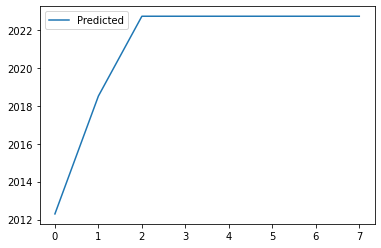

Input: [667.5 660.  697.5 705. ], Predicted: 708.589
Input: [660.    697.5   705.    708.589], Predicted: 713.555
Input: [697.5   705.    708.589 713.555], Predicted: 728.757
Input: [705.    708.589 713.555 728.757], Predicted: 728.884
Input: [708.589 713.555 728.757 728.884], Predicted: 723.931
Input: [713.555 728.757 728.884 723.931], Predicted: 724.284
Input: [728.757 728.884 723.931 724.284], Predicted: 723.598
Input: [728.884 723.931 724.284 723.598], Predicted: 721.547
ID_Material 120010342.0


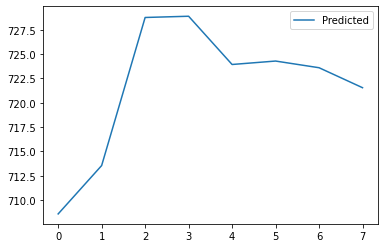

Input: [526.5 546.  487.5 370.5], Predicted: 358.634
Input: [546.    487.5   370.5   358.634], Predicted: 356.138
Input: [487.5   370.5   358.634 356.138], Predicted: 357.462
Input: [370.5   358.634 356.138 357.462], Predicted: 368.903
Input: [358.634 356.138 357.462 368.903], Predicted: 377.177
Input: [356.138 357.462 368.903 377.177], Predicted: 394.493
Input: [357.462 368.903 377.177 394.493], Predicted: 408.346
Input: [368.903 377.177 394.493 408.346], Predicted: 423.149
ID_Material 120009814.0


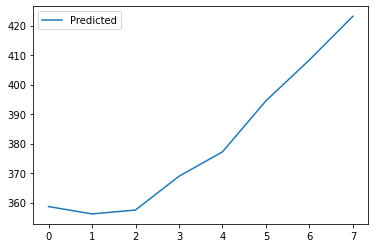

Input: [160. 185. 200. 225.], Predicted: 226.545
Input: [185.    200.    225.    226.545], Predicted: 227.325
Input: [200.    225.    226.545 227.325], Predicted: 227.210
Input: [225.    226.545 227.325 227.21 ], Predicted: 227.133
Input: [226.545 227.325 227.21  227.133], Predicted: 227.133
Input: [227.325 227.21  227.133 227.133], Predicted: 227.133
Input: [227.21  227.133 227.133 227.133], Predicted: 227.133
Input: [227.133 227.133 227.133 227.133], Predicted: 227.133
ID_Material 120015842.0


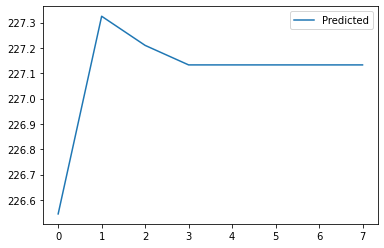

Input: [819.5   656.375 442.75  251.5  ], Predicted: 397.302
Input: [656.375 442.75  251.5   397.302], Predicted: 397.436
Input: [442.75  251.5   397.302 397.436], Predicted: 397.630
Input: [251.5   397.302 397.436 397.63 ], Predicted: 397.630
Input: [397.302 397.436 397.63  397.63 ], Predicted: 397.630
Input: [397.436 397.63  397.63  397.63 ], Predicted: 397.630
Input: [397.63 397.63 397.63 397.63], Predicted: 397.630
Input: [397.63 397.63 397.63 397.63], Predicted: 397.630
ID_Material 120012154.0


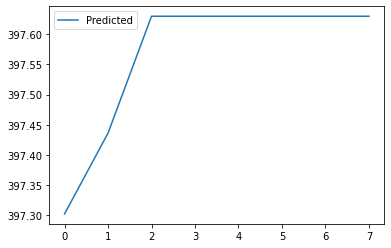

Input: [ 86.25  97.5  112.5  105.  ], Predicted: 108.479
Input: [ 97.5   112.5   105.    108.479], Predicted: 105.463
Input: [112.5   105.    108.479 105.463], Predicted: 108.458
Input: [105.    108.479 105.463 108.458], Predicted: 105.430
Input: [108.479 105.463 108.458 105.43 ], Predicted: 108.621
Input: [105.463 108.458 105.43  108.621], Predicted: 105.430
Input: [108.458 105.43  108.621 105.43 ], Predicted: 108.621
Input: [105.43  108.621 105.43  108.621], Predicted: 105.430
ID_Material 120004096.0


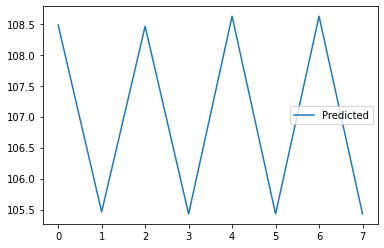

Input: [576. 558. 612. 576.], Predicted: 583.305
Input: [558.    612.    576.    583.305], Predicted: 568.864
Input: [612.    576.    583.305 568.864], Predicted: 553.561
Input: [576.    583.305 568.864 553.561], Predicted: 551.295
Input: [583.305 568.864 553.561 551.295], Predicted: 551.651
Input: [568.864 553.561 551.295 551.651], Predicted: 553.898
Input: [553.561 551.295 551.651 553.898], Predicted: 560.457
Input: [551.295 551.651 553.898 560.457], Predicted: 562.219
ID_Material 120009816.0


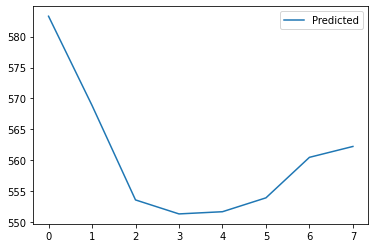

Input: [3570.  3444.  3465.  3433.5], Predicted: 3535.260
Input: [3444.   3465.   3433.5  3535.26], Predicted: 3535.260
Input: [3465.   3433.5  3535.26 3535.26], Predicted: 3535.260
Input: [3433.5  3535.26 3535.26 3535.26], Predicted: 3535.260
Input: [3535.26 3535.26 3535.26 3535.26], Predicted: 3535.260
Input: [3535.26 3535.26 3535.26 3535.26], Predicted: 3535.260
Input: [3535.26 3535.26 3535.26 3535.26], Predicted: 3535.260
Input: [3535.26 3535.26 3535.26 3535.26], Predicted: 3535.260
ID_Material 120011782.0


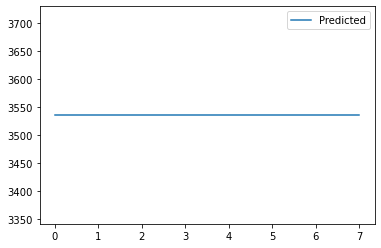

Input: [ 850.5  1039.5  1275.75 1606.5 ], Predicted: 1677.171
Input: [1039.5   1275.75  1606.5   1677.171], Predicted: 1675.513
Input: [1275.75  1606.5   1677.171 1675.513], Predicted: 1650.923
Input: [1606.5   1677.171 1675.513 1650.923], Predicted: 1642.126
Input: [1677.171 1675.513 1650.923 1642.126], Predicted: 1643.934
Input: [1675.513 1650.923 1642.126 1643.934], Predicted: 1643.802
Input: [1650.923 1642.126 1643.934 1643.802], Predicted: 1640.872
Input: [1642.126 1643.934 1643.802 1640.872], Predicted: 1642.197
ID_Material 120014486.0


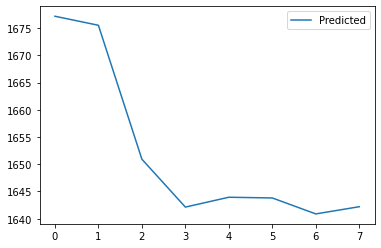

Input: [2443.5 2551.5 2389.5 2281.5], Predicted: 2137.466
Input: [2551.5   2389.5   2281.5   2137.466], Predicted: 2072.409
Input: [2389.5   2281.5   2137.466 2072.409], Predicted: 2009.916
Input: [2281.5   2137.466 2072.409 2009.916], Predicted: 2025.379
Input: [2137.466 2072.409 2009.916 2025.379], Predicted: 2087.823
Input: [2072.409 2009.916 2025.379 2087.823], Predicted: 2171.668
Input: [2009.916 2025.379 2087.823 2171.668], Predicted: 2277.628
Input: [2025.379 2087.823 2171.668 2277.628], Predicted: 2326.010
ID_Material 120014488.0


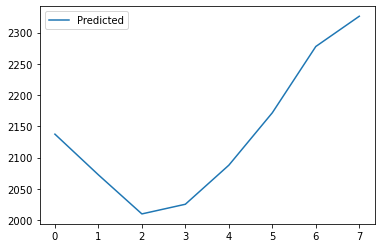

Input: [ 712.25  720.25  840.   1023.5 ], Predicted: 1077.478
Input: [ 720.25   840.    1023.5   1077.478], Predicted: 1142.102
Input: [ 840.    1023.5   1077.478 1142.102], Predicted: 1139.296
Input: [1023.5   1077.478 1142.102 1139.296], Predicted: 1127.801
Input: [1077.478 1142.102 1139.296 1127.801], Predicted: 1121.344
Input: [1142.102 1139.296 1127.801 1121.344], Predicted: 1121.527
Input: [1139.296 1127.801 1121.344 1121.527], Predicted: 1121.477
Input: [1127.801 1121.344 1121.527 1121.477], Predicted: 1121.447
ID_Material 120015996.0


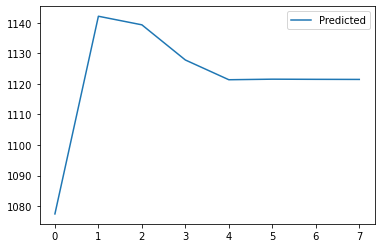

In [120]:
Results = pd.DataFrame()

for i in mo_avg["ID_material"].unique():
    j = mo_avg[mo_avg["ID_material"] == i]
    values = retrieve_val(j)

    train = series_to_supervised(values, n_in=4)

    trainX, trainy = train[:, :-1], train[:, -1]


    # fit model
    model = RandomForestRegressor(n_estimators=1000,
                           max_depth= 39,
                           min_samples_split=19,
                           min_samples_leaf=7, 
                           random_state = 0)

    model.fit(trainX, trainy)

    row = values[-4:].flatten()

    future_predictions = []

    for j in range(1,9):
        model.fit(trainX, trainy)

        row = row[-4:].flatten()

        yhat = model.predict(np.asarray([row]))
        future_predictions.append(round(yhat[0], 3))
        
        print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

        row = np.append(row, round(yhat[0], 3))
        row = np.delete(row,0)
        
    
    Results["Pred",i] = future_predictions
    
    print("ID_Material", i)
    plt.plot(future_predictions, label='Predicted')
    plt.legend()
    plt.show()
    

In [122]:
Results

,"(Pred, 120010970.0)","(Pred, 120012606.0)","(Pred, 120011556.0)","(Pred, 120010566.0)","(Pred, 120010342.0)","(Pred, 120009814.0)","(Pred, 120015842.0)","(Pred, 120012154.0)","(Pred, 120004096.0)","(Pred, 120009816.0)","(Pred, 120011782.0)","(Pred, 120014486.0)","(Pred, 120014488.0)","(Pred, 120015996.0)"
0,1233.747,1103.771,215.893,2012.296,708.589,358.634,226.545,397.302,108.479,583.305,3535.26,1677.171,2137.466,1077.478
1,1230.519,1115.904,212.823,2018.520,713.555,356.138,227.325,397.436,105.463,568.864,3535.26,1675.513,2072.409,1142.102
2,1192.519,1066.068,209.670,2022.735,728.757,357.462,227.210,397.630,108.458,553.561,3535.26,1650.923,2009.916,1139.296
3,1182.237,1040.764,213.301,2022.735,728.884,368.903,227.133,397.630,105.430,551.295,3535.26,1642.126,2025.379,1127.801
4,1181.053,1021.590,214.427,2022.735,723.931,377.177,227.133,397.630,108.621,551.651,3535.26,1643.934,2087.823,1121.344
5,1171.184,1024.063,215.342,2022.735,724.284,394.493,227.133,397.630,105.430,553.898,3535.26,1643.802,2171.668,1121.527
6,1168.551,1034.175,215.821,2022.735,723.598,408.346,227.133,397.630,108.621,560.457,3535.26,1640.872,2277.628,1121.477
7,1168.613,1034.738,215.771,2022.735,721.547,423.149,227.133,397.630,105.430,562.219,3535.26,1642.197,2326.010,1121.447


In [121]:
Results.to_csv("Results.csv")

,"(Pred, 120010970.0)","(Pred, 120012606.0)","(Pred, 120011556.0)","(Pred, 120010566.0)","(Pred, 120010342.0)","(Pred, 120009814.0)","(Pred, 120015842.0)","(Pred, 120012154.0)","(Pred, 120004096.0)","(Pred, 120009816.0)","(Pred, 120011782.0)","(Pred, 120014486.0)","(Pred, 120014488.0)","(Pred, 120015996.0)"
0,1233.747,1103.771,215.893,2012.296,708.589,358.634,226.545,397.302,108.479,583.305,3535.26,1677.171,2137.466,1077.478
1,1230.519,1115.904,212.823,2018.520,713.555,356.138,227.325,397.436,105.463,568.864,3535.26,1675.513,2072.409,1142.102
2,1192.519,1066.068,209.670,2022.735,728.757,357.462,227.210,397.630,108.458,553.561,3535.26,1650.923,2009.916,1139.296
3,1182.237,1040.764,213.301,2022.735,728.884,368.903,227.133,397.630,105.430,551.295,3535.26,1642.126,2025.379,1127.801
4,1181.053,1021.590,214.427,2022.735,723.931,377.177,227.133,397.630,108.621,551.651,3535.26,1643.934,2087.823,1121.344
5,1171.184,1024.063,215.342,2022.735,724.284,394.493,227.133,397.630,105.430,553.898,3535.26,1643.802,2171.668,1121.527
6,1168.551,1034.175,215.821,2022.735,723.598,408.346,227.133,397.630,108.621,560.457,3535.26,1640.872,2277.628,1121.477
7,1168.613,1034.738,215.771,2022.735,721.547,423.149,227.133,397.630,105.430,562.219,3535.26,1642.197,2326.010,1121.447


## Gradient Boosting 

Now we apply the same methodology for Gradient Boosting in order to compare both models. One aspect of Gradient Boosting that needs to be considered is the high possibility of Overfitting due to the weights on the decision trees being constantly retrained

>expected=787.5, predicted=965.2
>expected=727.5, predicted=854.5
>expected=832.5, predicted=780.9
>expected=926.2, predicted=1185.7
>expected=1008.8, predicted=1193.1
>expected=1038.8, predicted=1267.3
>expected=1123.1, predicted=976.5
>expected=1179.4, predicted=1220.0
Accuracy: 0.991
MAE: 151.977
MAPE: 0.164
ID_material:  120010970.0


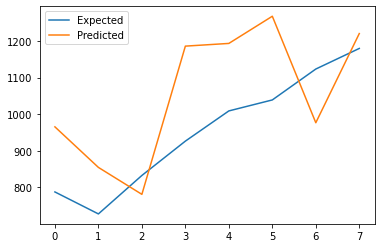

>expected=726.2, predicted=1138.4
>expected=350.0, predicted=810.9
>expected=586.2, predicted=746.6
>expected=796.2, predicted=383.7
>expected=770.0, predicted=430.6
>expected=796.2, predicted=666.1
>expected=1111.2, predicted=691.3
>expected=1111.2, predicted=1037.5
Accuracy: 0.988
MAE: 301.162
MAPE: 0.466
ID_material:  120012606.0


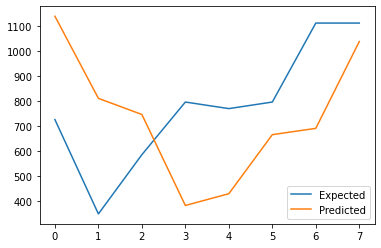

>expected=309.8, predicted=259.5
>expected=303.0, predicted=251.9
>expected=358.5, predicted=263.9
>expected=393.0, predicted=295.4
>expected=394.5, predicted=392.8
>expected=379.5, predicted=393.7
>expected=370.5, predicted=389.0
>expected=224.2, predicted=384.4
Accuracy: -0.073
MAE: 61.014
MAPE: 0.206
ID_material:  120011556.0


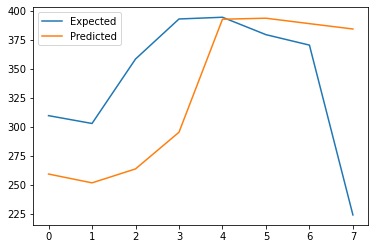

>expected=5880.0, predicted=5067.2
>expected=5607.0, predicted=5008.9
>expected=5061.0, predicted=4813.5
>expected=4315.5, predicted=4790.4
>expected=3654.0, predicted=3923.5
>expected=2908.5, predicted=3192.5
>expected=2079.0, predicted=2826.5
>expected=1165.5, predicted=2011.1
Accuracy: 0.964
MAE: 534.981
MAPE: 0.208
ID_material:  120010566.0


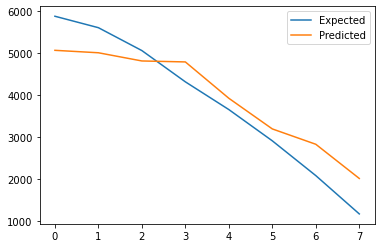

>expected=705.0, predicted=693.5
>expected=660.0, predicted=733.6
>expected=637.5, predicted=753.5
>expected=637.5, predicted=627.5
>expected=667.5, predicted=647.0
>expected=660.0, predicted=736.8
>expected=697.5, predicted=662.8
>expected=705.0, predicted=761.9
Accuracy: 0.414
MAE: 49.998
MAPE: 0.075
ID_material:  120010342.0


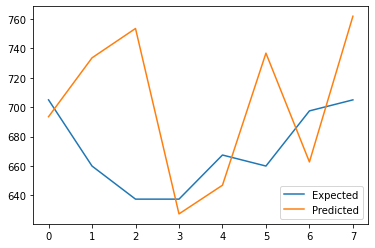

>expected=507.0, predicted=527.9
>expected=507.0, predicted=533.6
>expected=585.0, predicted=457.3
>expected=585.0, predicted=565.1
>expected=526.5, predicted=578.2
>expected=546.0, predicted=561.4
>expected=487.5, predicted=463.8
>expected=370.5, predicted=535.0
Accuracy: 0.171
MAE: 56.295
MAPE: 0.121
ID_material:  120009814.0


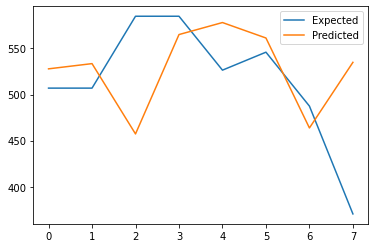

>expected=205.0, predicted=195.0
>expected=185.0, predicted=180.7
>expected=200.0, predicted=167.6
>expected=160.0, predicted=262.7
>expected=160.0, predicted=165.4
>expected=185.0, predicted=194.1
>expected=200.0, predicted=167.2
>expected=225.0, predicted=197.3
Accuracy: 0.780
MAE: 28.051
MAPE: 0.156
ID_material:  120015842.0


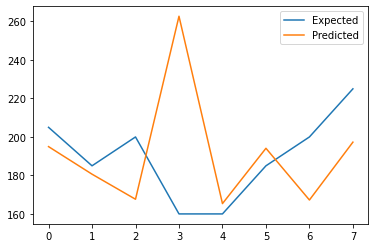

>expected=1633.5, predicted=1584.1
>expected=1374.8, predicted=1744.3
>expected=1138.5, predicted=1149.1
>expected=1016.4, predicted=781.1
>expected=819.5, predicted=934.9
>expected=656.4, predicted=861.4
>expected=442.8, predicted=633.5
>expected=251.5, predicted=424.7
Accuracy: 0.942
MAE: 168.655
MAPE: 0.264
ID_material:  120012154.0


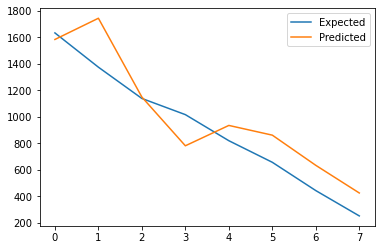

>expected=63.8, predicted=87.5
>expected=63.8, predicted=68.8
>expected=63.8, predicted=79.2
>expected=63.8, predicted=77.2
>expected=86.2, predicted=73.0
>expected=97.5, predicted=95.3
>expected=112.5, predicted=130.6
>expected=105.0, predicted=107.8
Accuracy: 0.993
MAE: 11.769
MAPE: 0.159
ID_material:  120004096.0


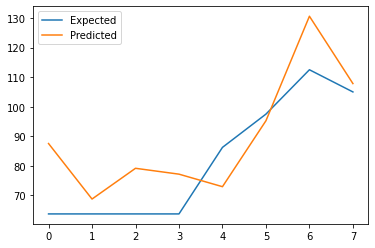

>expected=792.0, predicted=846.9
>expected=630.0, predicted=862.2
>expected=684.0, predicted=572.2
>expected=630.0, predicted=639.1
>expected=576.0, predicted=646.7
>expected=558.0, predicted=608.5
>expected=612.0, predicted=447.2
>expected=576.0, predicted=461.3
Accuracy: 0.675
MAE: 101.082
MAPE: 0.162
ID_material:  120009816.0


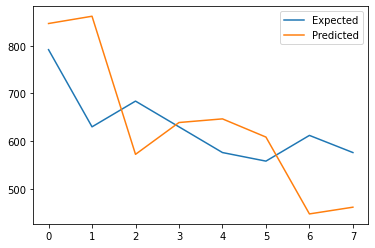

>expected=3654.0, predicted=3607.7
>expected=3654.0, predicted=3666.9
>expected=3605.0, predicted=3673.0
>expected=3633.0, predicted=3665.9
>expected=3570.0, predicted=3665.4
>expected=3444.0, predicted=3632.7
>expected=3465.0, predicted=3496.3
>expected=3433.5, predicted=3480.0
Accuracy: 0.936
MAE: 65.256
MAPE: 0.019
ID_material:  120011782.0


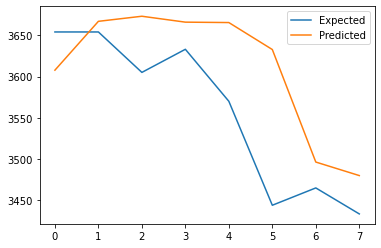

>expected=992.2, predicted=1249.8
>expected=960.8, predicted=850.0
>expected=1008.0, predicted=891.4
>expected=803.2, predicted=1063.9
>expected=850.5, predicted=813.3
>expected=1039.5, predicted=894.1
>expected=1275.8, predicted=936.3
>expected=1606.5, predicted=1493.7
Accuracy: 0.973
MAE: 172.557
MAPE: 0.167
ID_material:  120014486.0


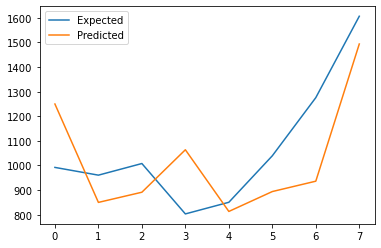

>expected=2956.5, predicted=2799.1
>expected=2929.5, predicted=2988.1
>expected=3132.0, predicted=2998.8
>expected=3037.5, predicted=3249.0
>expected=2443.5, predicted=2890.5
>expected=2551.5, predicted=2189.6
>expected=2389.5, predicted=2680.5
>expected=2281.5, predicted=2587.6
Accuracy: 0.879
MAE: 245.849
MAPE: 0.096
ID_material:  120014488.0


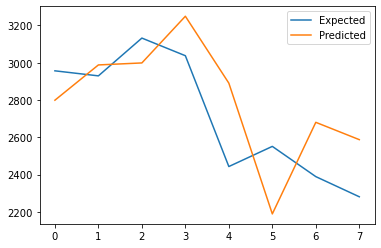

>expected=1121.1, predicted=1101.0
>expected=1012.2, predicted=932.8
>expected=1034.6, predicted=1023.9
>expected=803.2, predicted=1279.1
>expected=712.2, predicted=1135.4
>expected=720.2, predicted=1025.7
>expected=840.0, predicted=956.3
>expected=1023.5, predicted=1014.1
Accuracy: 0.999
MAE: 180.054
MAPE: 0.233
ID_material:  120015996.0


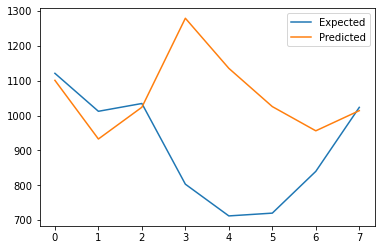

In [124]:
for i in mo_avg["ID_material"].unique():
    j = mo_avg[mo_avg["ID_material"] == i]
    values = retrieve_val(j)
    new_data = series_to_supervised(values, n_in=4)
    accuracy, mape, mae, y, yhat = walk_forward_validation(new_data,gradient_boosting_forecast, 8)
    print('Accuracy: %.3f' % accuracy)
    print('MAE: %.3f' % mae)
    print('MAPE: %.3f' % mape)

    # plot expected vs predicted
    print("ID_material: ", i)
    plt.plot(y, label='Expected')
    plt.plot(yhat, label='Predicted')
    plt.legend()
    plt.show()


### Results: 
We have some very interesting results with the Gradient Boosting Regressor showing very high accuracy results across multiple ID_Materials. For example: 

- 120010970.0 --> 99.1% Accuracy
- 120012606.0 --> 98.8% Accuracy 
- 120010566.0 --> 96.4% Accuracy 

However, after further examination, the MAPE is on average lower when compared to the Random Forest Regressor.

Following this we will generate the next 8 week predictions of each ID_material

Input: [1008.75  1038.75  1123.125 1179.375], Predicted: 1133.449
Input: [1038.75  1123.125 1179.375 1133.449], Predicted: 1228.642
Input: [1123.125 1179.375 1133.449 1228.642], Predicted: 1144.956
Input: [1179.375 1133.449 1228.642 1144.956], Predicted: 1135.881
Input: [1133.449 1228.642 1144.956 1135.881], Predicted: 1246.188
Input: [1228.642 1144.956 1135.881 1246.188], Predicted: 1220.306
Input: [1144.956 1135.881 1246.188 1220.306], Predicted: 1150.481
Input: [1135.881 1246.188 1220.306 1150.481], Predicted: 1139.305
ID_Material 120010970.0


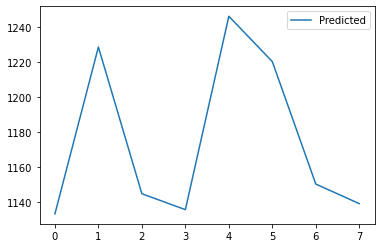

Input: [ 770.    796.25 1111.25 1111.25], Predicted: 1112.803
Input: [ 796.25  1111.25  1111.25  1112.803], Predicted: 1142.099
Input: [1111.25  1111.25  1112.803 1142.099], Predicted: 1059.388
Input: [1111.25  1112.803 1142.099 1059.388], Predicted: 1031.511
Input: [1112.803 1142.099 1059.388 1031.511], Predicted: 974.547
Input: [1142.099 1059.388 1031.511  974.547], Predicted: 1164.860
Input: [1059.388 1031.511  974.547 1164.86 ], Predicted: 1066.033
Input: [1031.511  974.547 1164.86  1066.033], Predicted: 1068.184
ID_Material 120012606.0


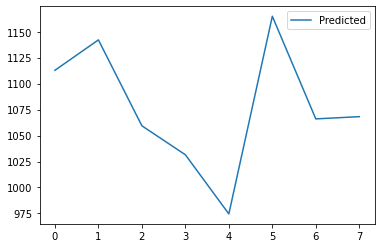

Input: [394.5  379.5  370.5  224.25], Predicted: 235.322
Input: [379.5   370.5   224.25  235.322], Predicted: 251.189
Input: [370.5   224.25  235.322 251.189], Predicted: 217.981
Input: [224.25  235.322 251.189 217.981], Predicted: 221.072
Input: [235.322 251.189 217.981 221.072], Predicted: 217.654
Input: [251.189 217.981 221.072 217.654], Predicted: 186.908
Input: [217.981 221.072 217.654 186.908], Predicted: 181.317
Input: [221.072 217.654 186.908 181.317], Predicted: 173.496
ID_Material 120011556.0


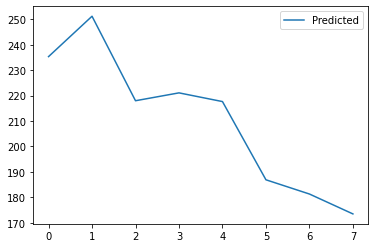

Input: [3654.  2908.5 2079.  1165.5], Predicted: 1683.366
Input: [2908.5   2079.    1165.5   1683.366], Predicted: 1822.544
Input: [2079.    1165.5   1683.366 1822.544], Predicted: 2125.712
Input: [1165.5   1683.366 1822.544 2125.712], Predicted: 2186.768
Input: [1683.366 1822.544 2125.712 2186.768], Predicted: 2787.626
Input: [1822.544 2125.712 2186.768 2787.626], Predicted: 3325.793
Input: [2125.712 2186.768 2787.626 3325.793], Predicted: 3809.240
Input: [2186.768 2787.626 3325.793 3809.24 ], Predicted: 4021.587
ID_Material 120010566.0


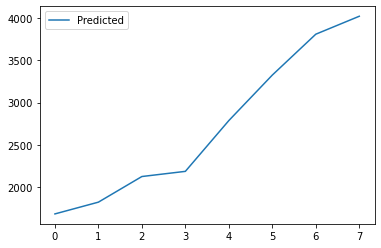

Input: [667.5 660.  697.5 705. ], Predicted: 689.194
Input: [660.    697.5   705.    689.194], Predicted: 708.476
Input: [697.5   705.    689.194 708.476], Predicted: 714.948
Input: [705.    689.194 708.476 714.948], Predicted: 746.428
Input: [689.194 708.476 714.948 746.428], Predicted: 791.473
Input: [708.476 714.948 746.428 791.473], Predicted: 785.619
Input: [714.948 746.428 791.473 785.619], Predicted: 764.628
Input: [746.428 791.473 785.619 764.628], Predicted: 810.826
ID_Material 120010342.0


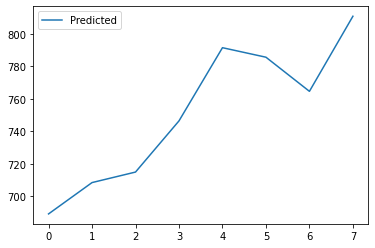

Input: [526.5 546.  487.5 370.5], Predicted: 320.633
Input: [546.    487.5   370.5   320.633], Predicted: 196.109
Input: [487.5   370.5   320.633 196.109], Predicted: 215.538
Input: [370.5   320.633 196.109 215.538], Predicted: 188.548
Input: [320.633 196.109 215.538 188.548], Predicted: 248.322
Input: [196.109 215.538 188.548 248.322], Predicted: 320.601
Input: [215.538 188.548 248.322 320.601], Predicted: 293.880
Input: [188.548 248.322 320.601 293.88 ], Predicted: 310.006
ID_Material 120009814.0


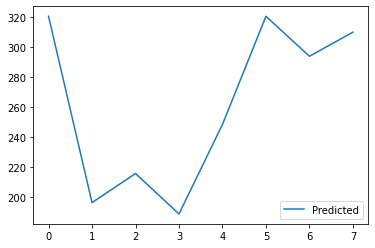

Input: [160. 185. 200. 225.], Predicted: 247.967
Input: [185.    200.    225.    247.967], Predicted: 295.548
Input: [200.    225.    247.967 295.548], Predicted: 320.042
Input: [225.    247.967 295.548 320.042], Predicted: 357.083
Input: [247.967 295.548 320.042 357.083], Predicted: 331.636
Input: [295.548 320.042 357.083 331.636], Predicted: 313.606
Input: [320.042 357.083 331.636 313.606], Predicted: 322.224
Input: [357.083 331.636 313.606 322.224], Predicted: 357.593
ID_Material 120015842.0


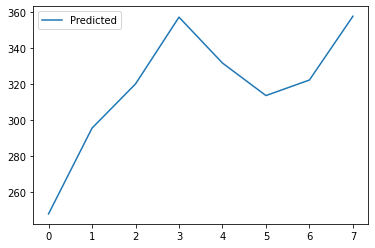

Input: [819.5   656.375 442.75  251.5  ], Predicted: 318.829
Input: [656.375 442.75  251.5   318.829], Predicted: 386.830
Input: [442.75  251.5   318.829 386.83 ], Predicted: 420.473
Input: [251.5   318.829 386.83  420.473], Predicted: 428.079
Input: [318.829 386.83  420.473 428.079], Predicted: 371.209
Input: [386.83  420.473 428.079 371.209], Predicted: 316.641
Input: [420.473 428.079 371.209 316.641], Predicted: 326.024
Input: [428.079 371.209 316.641 326.024], Predicted: 417.324
ID_Material 120012154.0


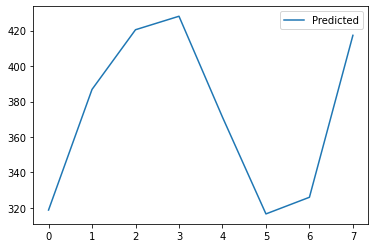

Input: [ 86.25  97.5  112.5  105.  ], Predicted: 105.148
Input: [ 97.5   112.5   105.    105.148], Predicted: 126.989
Input: [112.5   105.    105.148 126.989], Predicted: 127.585
Input: [105.    105.148 126.989 127.585], Predicted: 120.044
Input: [105.148 126.989 127.585 120.044], Predicted: 106.082
Input: [126.989 127.585 120.044 106.082], Predicted: 97.655
Input: [127.585 120.044 106.082  97.655], Predicted: 90.766
Input: [120.044 106.082  97.655  90.766], Predicted: 112.279
ID_Material 120004096.0


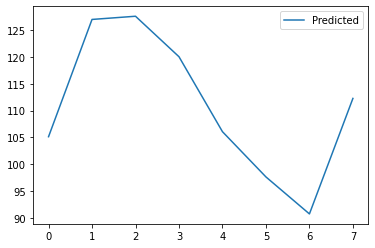

Input: [576. 558. 612. 576.], Predicted: 626.722
Input: [558.    612.    576.    626.722], Predicted: 543.482
Input: [612.    576.    626.722 543.482], Predicted: 481.546
Input: [576.    626.722 543.482 481.546], Predicted: 490.545
Input: [626.722 543.482 481.546 490.545], Predicted: 489.010
Input: [543.482 481.546 490.545 489.01 ], Predicted: 463.788
Input: [481.546 490.545 489.01  463.788], Predicted: 452.065
Input: [490.545 489.01  463.788 452.065], Predicted: 428.478
ID_Material 120009816.0


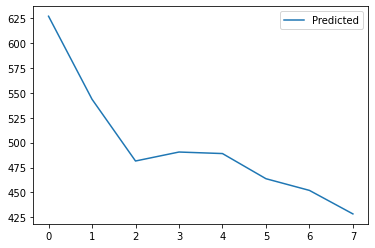

Input: [3570.  3444.  3465.  3433.5], Predicted: 3446.548
Input: [3444.    3465.    3433.5   3446.548], Predicted: 3530.763
Input: [3465.    3433.5   3446.548 3530.763], Predicted: 3480.683
Input: [3433.5   3446.548 3530.763 3480.683], Predicted: 3467.916
Input: [3446.548 3530.763 3480.683 3467.916], Predicted: 3553.538
Input: [3530.763 3480.683 3467.916 3553.538], Predicted: 3545.381
Input: [3480.683 3467.916 3553.538 3545.381], Predicted: 3467.784
Input: [3467.916 3553.538 3545.381 3467.784], Predicted: 3553.538
ID_Material 120011782.0


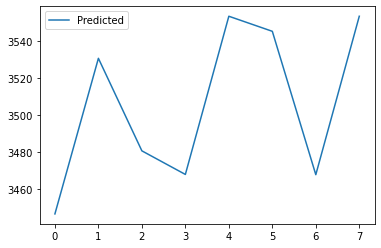

Input: [ 850.5  1039.5  1275.75 1606.5 ], Predicted: 1715.681
Input: [1039.5   1275.75  1606.5   1715.681], Predicted: 1860.310
Input: [1275.75  1606.5   1715.681 1860.31 ], Predicted: 1982.596
Input: [1606.5   1715.681 1860.31  1982.596], Predicted: 1876.865
Input: [1715.681 1860.31  1982.596 1876.865], Predicted: 1924.821
Input: [1860.31  1982.596 1876.865 1924.821], Predicted: 1913.855
Input: [1982.596 1876.865 1924.821 1913.855], Predicted: 1721.318
Input: [1876.865 1924.821 1913.855 1721.318], Predicted: 1579.440
ID_Material 120014486.0


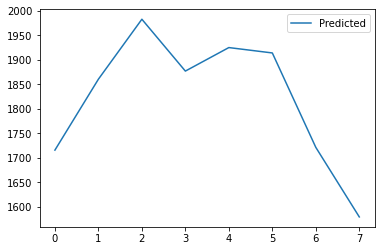

Input: [2443.5 2551.5 2389.5 2281.5], Predicted: 1988.181
Input: [2551.5   2389.5   2281.5   1988.181], Predicted: 1896.651
Input: [2389.5   2281.5   1988.181 1896.651], Predicted: 1831.684
Input: [2281.5   1988.181 1896.651 1831.684], Predicted: 1675.960
Input: [1988.181 1896.651 1831.684 1675.96 ], Predicted: 1378.403
Input: [1896.651 1831.684 1675.96  1378.403], Predicted: 1607.312
Input: [1831.684 1675.96  1378.403 1607.312], Predicted: 1289.492
Input: [1675.96  1378.403 1607.312 1289.492], Predicted: 1173.426
ID_Material 120014488.0


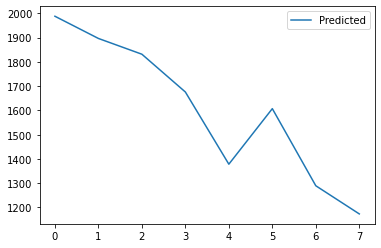

Input: [ 712.25  720.25  840.   1023.5 ], Predicted: 1214.672
Input: [ 720.25   840.    1023.5   1214.672], Predicted: 1636.522
Input: [ 840.    1023.5   1214.672 1636.522], Predicted: 1767.596
Input: [1023.5   1214.672 1636.522 1767.596], Predicted: 1829.084
Input: [1214.672 1636.522 1767.596 1829.084], Predicted: 1566.998
Input: [1636.522 1767.596 1829.084 1566.998], Predicted: 1687.634
Input: [1767.596 1829.084 1566.998 1687.634], Predicted: 1740.001
Input: [1829.084 1566.998 1687.634 1740.001], Predicted: 1852.001
ID_Material 120015996.0


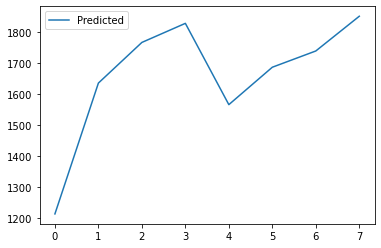

In [125]:
Results_Boosting = pd.DataFrame()

for i in mo_avg["ID_material"].unique():
    j = mo_avg[mo_avg["ID_material"] == i]
    values = retrieve_val(j)

    train = series_to_supervised(values, n_in=4)

    trainX, trainy = train[:, :-1], train[:, -1]


    # fit model
    model = GradientBoostingRegressor(n_estimators=1000,
                           max_depth= 39,
                           min_samples_split=19,
                           min_samples_leaf=7,
                            random_state = 0)

    model.fit(trainX, trainy)

    row = values[-4:].flatten()

    future_predictions = []

    for j in range(1,9):
        model.fit(trainX, trainy)

        row = row[-4:].flatten()

        yhat = model.predict(np.asarray([row]))
        future_predictions.append(round(yhat[0], 3))

        print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

        row = np.append(row, round(yhat[0], 3))
        row = np.delete(row,0)
    
    Results_Boosting["Pred",i] = future_predictions

    print("ID_Material", i)
    plt.plot(future_predictions, label='Predicted')
    plt.legend()
    plt.show()

In [126]:
Results_Boosting

,"(Pred, 120010970.0)","(Pred, 120012606.0)","(Pred, 120011556.0)","(Pred, 120010566.0)","(Pred, 120010342.0)","(Pred, 120009814.0)","(Pred, 120015842.0)","(Pred, 120012154.0)","(Pred, 120004096.0)","(Pred, 120009816.0)","(Pred, 120011782.0)","(Pred, 120014486.0)","(Pred, 120014488.0)","(Pred, 120015996.0)"
0,1133.449,1112.803,235.322,1683.366,689.194,320.633,247.967,318.829,105.148,626.722,3446.548,1715.681,1988.181,1214.672
1,1228.642,1142.099,251.189,1822.544,708.476,196.109,295.548,386.830,126.989,543.482,3530.763,1860.310,1896.651,1636.522
2,1144.956,1059.388,217.981,2125.712,714.948,215.538,320.042,420.473,127.585,481.546,3480.683,1982.596,1831.684,1767.596
3,1135.881,1031.511,221.072,2186.768,746.428,188.548,357.083,428.079,120.044,490.545,3467.916,1876.865,1675.960,1829.084
4,1246.188,974.547,217.654,2787.626,791.473,248.322,331.636,371.209,106.082,489.010,3553.538,1924.821,1378.403,1566.998
5,1220.306,1164.860,186.908,3325.793,785.619,320.601,313.606,316.641,97.655,463.788,3545.381,1913.855,1607.312,1687.634
6,1150.481,1066.033,181.317,3809.240,764.628,293.880,322.224,326.024,90.766,452.065,3467.784,1721.318,1289.492,1740.001
7,1139.305,1068.184,173.496,4021.587,810.826,310.006,357.593,417.324,112.279,428.478,3553.538,1579.440,1173.426,1852.001


In [127]:
Results_Boosting.to_csv("Results_Boosting.csv")

## Conclusion

After an examination of both models utilised, it was concluded that the Random Forest Regressor is the most suitable and effective model due to:
- Lower MAPE and MAE
- Lower chance of overfitting our results
- More in-tune with moving average and presenting less volatility 